In this notebook, we'll extract social networks from text, where nodes are characters and the edges between them are weighted by the strength of their connection (defined as being mentioned together within some window of words).  Identifying these kinds of implicit networks allows us to visualize the connections within them, and also determine the structural properties of the characters within the network topology (such as degree centrality, betweenness centrality and closeness centrality).

In [ ]:
!pip install networkx

In [ ]:
!pip install matplotlib

In [1]:
import json
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import operator

In [2]:
def read_character_locations(filename):
    locs=[]
    lastChar=None
    with open(filename) as file:
        file.readline()
        for idx, line in enumerate(file):
            cols=line.rstrip().split("\t")
            charid=int(cols[14])
            if charid != -1 and charid != lastChar:
                locs.append((charid, idx))
            lastChar=charid
    return locs

In [3]:
character_locs=read_character_locations("../data/pride_and_prejudice.tokens")

In [4]:
def get_character_names(filename):
    
    names={}
    
    with open(filename) as file:
        data=json.load(file)
        
        for character in data["characters"]:
            idd=int(character["id"])
            char_names=character["names"]
            names[idd]=char_names[0]["n"]
            
    return names

In [5]:
character_names=get_character_names("../data/pride_and_prejudice.book")

In [6]:
def get_character_coocurrence_counts(character_names, locs, window=25):
    nodes=Counter()
    edges={}

    for idx, (char_id, loc) in enumerate(locs):
        name1=character_names[char_id]
        nodes[name1]+=1
        if name1 not in edges:
            edges[name1]=Counter()

        nextChar=idx

        while nextChar < len(locs)-1:
            nextChar+=1
            (next_char_id, next_loc)=locs[nextChar]

            if next_loc-loc > window:
                break

            name2=character_names[next_char_id]

            if next_char_id != char_id:
                edges[name1][name2]+=1
    
    
    return nodes, edges


In [7]:
nodes, edges=get_character_coocurrence_counts(character_names, character_locs, window=25)

In [8]:
def create_graph(nodes, edges, min_edge_weight=5):
    
    G = nx.Graph()
    for person in nodes:
        G.add_node(person, nodesize=nodes[person])
    for person1 in edges:
        for person2 in edges[person1]:
            if person1 in nodes and person2 in nodes and edges[person1][person2] > min_edge_weight:
                G.add_weighted_edges_from([(person1, person2, edges[person1][person2]) ])
    return G


In [9]:
G=create_graph(nodes, edges)

In [10]:
def display_graph(G):

    """ Plot a set of weighted nodes and weighted edges on a network graph """
    
    # increase this to expand network
    force_directed_expansion=10
    
    # increase these dimensions to make graph bigger
    figure_height=20
    figure_width=20
    


    options = {
    'edgecolors':"black",
    'linewidths':1,
    'with_labels': True,
    'font_weight': 'regular',
    }
    
    g_edges = G.edges()

    sizes = [G.nodes[node]['nodesize'] for node in G]
    weights = [G[u][v]['weight']/100. for u,v in g_edges]

    fig, ax = plt.subplots(1, 1, figsize=(figure_height, figure_width));

    nx.draw_networkx(G, pos=nx.spring_layout(G, k=force_directed_expansion, iterations=100), node_size=sizes, width=weights, **options)
    

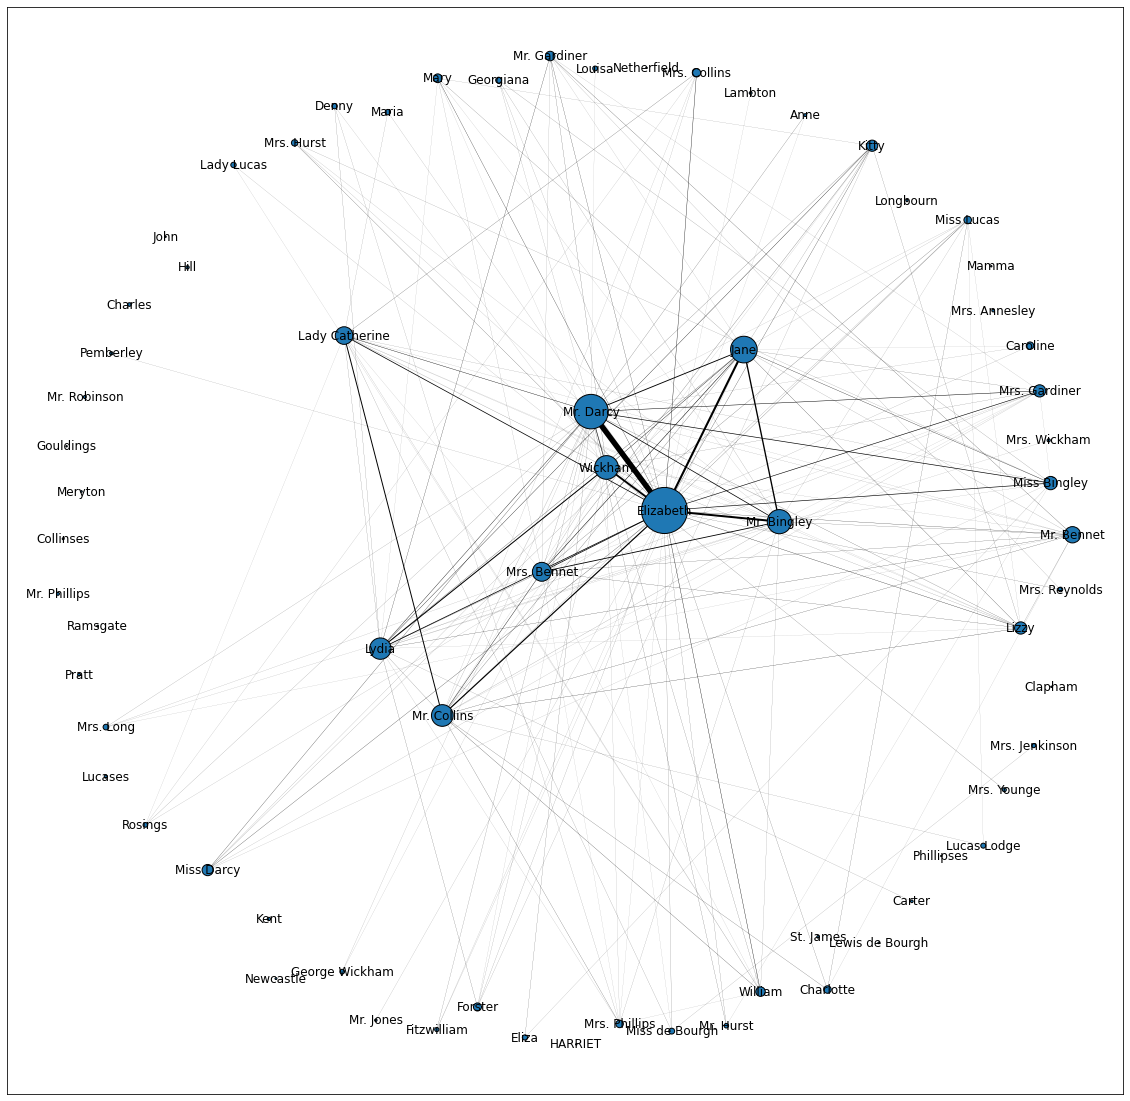

In [11]:
display_graph(G)

In [12]:
def print_top(measure, n=5):
    sorted_measure = sorted(measure.items(), key=operator.itemgetter(1), reverse=True)
    for node, val in sorted_measure[:5]:
        print("%s\t%.3f" % (node, val))

In [13]:
centrality=nx.degree_centrality(G)
print_top(centrality, n=5)

Elizabeth	0.529
Mr. Darcy	0.441
Mr. Bingley	0.279
Lydia	0.279
Wickham	0.279


In [14]:
betweenness_centrality=nx.betweenness_centrality(G)
print_top(betweenness_centrality, n=5)

Elizabeth	0.174
Mr. Darcy	0.102
Lydia	0.050
Wickham	0.038
Mr. Collins	0.021


In [15]:
closeness_centrality=nx.closeness_centrality(G)
print_top(closeness_centrality, n=5)

Elizabeth	0.556
Mr. Darcy	0.502
Mr. Bingley	0.421
Lydia	0.421
Wickham	0.421
